In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
import cv2
import IPython.display as ipd 
import librosa 
import librosa.display
import torch
import torch.nn.functional as F
import torchvision

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

c:\Users\pqtu2\miniconda3\envs\traindeep\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
train_path = '/freesound-audio-tagging/audio_train/'
train = pd.read_csv("freesound-audio-tagging/train.csv")
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [5]:
print(len(train.label.unique()))
print(train.label.unique())

41
['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


In [6]:
labels = np.unique(train.label.values)
label_encoder = {label:i for i, label in enumerate(labels)}

In [11]:
import torch
import numpy as np
import librosa
import cv2
from torch.utils.data import Dataset, DataLoader
import math

# Define constants
IMG_SIZE = (128, 87)
SPEC_PATH = 'spectrograms'

class AudioDataset(Dataset):
    def __init__(self, dataframe, is_train=True):
        self.dataframe = dataframe
        self.is_train = is_train

    def __getitem__(self, index):
        FILE = self.dataframe.fname.values[index]
        LABEL = self.dataframe.label.values[index]

        # Try loading from the specified set (train or test)
        SET = 'train_spec' if self.is_train else 'test_spec'
        path = f'{SPEC_PATH}/{SET}/{FILE[:-4]}.npy'
        
        try:
            data_array = np.load(path)
        except FileNotFoundError:
            # If not found, switch to the other set
            SET = 'test_spec' if self.is_train else 'train_spec'
            path = f'{SPEC_PATH}/{SET}/{FILE[:-4]}.npy'
            try:
                data_array = np.load(path)
            except FileNotFoundError:
                print(f"Error: File not found in either train_spec or test_spec: {path}")
                return None, None

        resized = cv2.resize(data_array, (IMG_SIZE[1], IMG_SIZE[0]))
        X = np.zeros(shape=(3, IMG_SIZE[0], IMG_SIZE[1]))
        for j in range(3):
            X[j,:,:] = resized

        if self.is_train:
            y = label_encoder[LABEL]  # Assuming you have a label encoder defined
            return torch.tensor(X, dtype=torch.float), y
        else:
            return torch.tensor(X, dtype=torch.float)

    def __len__(self):
        return self.dataframe.shape[0]


# # Example usage:
# train_df = # your training dataframe
# test_df = # your testing dataframe
train_dd, test_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)
train_df, val_df = train_test_split(train_dd, test_size=0.2, random_state=1, stratify=train_dd.label)

train_dataset = AudioDataset(train_df, is_train=True)
val_dataset = AudioDataset(val_df, is_train=True)
test_dataset = AudioDataset(test_df, is_train=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Iterate through the data loaders:
for batch_idx, (data, target) in enumerate(train_loader):
    # Do your training logic here
    print(f"Batch {batch_idx}: data shape {data.shape}, target shape {target.shape}")

for batch_idx, (data, target) in enumerate(test_loader):
    # Do your testing logic here
    print(f"Batch {batch_idx}: data shape {data.shape}, target shape {target.shape}")

Batch 0: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 1: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 2: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 3: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 4: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 5: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 6: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 7: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 8: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 9: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 10: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 11: data shape torch.Size([32, 3, 128, 87]), target shape torch.Size([32])
Batch 12: data shape torch.Size([32, 3

In [12]:
features = dict(
    train = train_loader,
    val = val_loader,
    test = test_loader
)

In [13]:
import pickle

# Lưu danh sách vào tệp
with open('feature_dataloader.pkl', 'wb') as file:
    pickle.dump(features, file)

In [14]:
# model = torchvision.models.efficientnet_b0(pretrained=True)
# model.classifier[1] = torch.nn.Linear(1280, 41)

model = torchvision.models.mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 41)

model.to(device);

c:\Users\pqtu2\miniconda3\envs\traindeep\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pqtu2\miniconda3\envs\traindeep\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\pqtu2/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 17.7MB/s]


In [8]:
# from torchsummary import summary
# summary(model, (3, 224, 224))

In [15]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
cost = torch.nn.CrossEntropyLoss()

In [16]:
# Save the state of the model
torch.save(model.state_dict(), 'model_state.pth')


In [11]:
model.load_state_dict(torch.load('model_state.pth'))

<All keys matched successfully>

# Testing Training

In [1]:
from env import *
from helper import *
from agent import *
import torchvision

dataset = 'freesound'
train_epochs = 1
accuracy_weight = 0.72
num_groups_per_layer = 2
num_layers_unfreeze_per_epoch = 5
param = 'mbv2_freesound.pth'

print('BEGIN TRAINING WITH DATASET', dataset)
model = torchvision.models.mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 41)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device);


c:\Users\pqtu2\miniconda3\envs\traindeep\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


BEGIN TRAINING WITH DATASET freesound


c:\Users\pqtu2\miniconda3\envs\traindeep\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pqtu2\miniconda3\envs\traindeep\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
env = Environment(model, num_groups_per_layer, num_layers_unfreeze_per_epoch, train_epochs, param, dataset)
env.action_step(1)
env.get_state()

TypeError: 'NoneType' object does not support item assignment

# Gradual Unfreeze

Training... with total group layers 104, divided by groups of 2 per layer
--- group layers unfreezed: 0 
Epoch [1/1], Train Loss: 3.2043, Train Accuracy: 19.43%, Val Loss: 2.7303, Val Accuracy: 33.71%
--- group layers unfreezed: 5 
Epoch [1/1], Train Loss: 1.9467, Train Accuracy: 47.23%, Val Loss: 1.5507, Val Accuracy: 57.45%
--- group layers unfreezed: 10 
Epoch [1/1], Train Loss: 1.4371, Train Accuracy: 60.67%, Val Loss: 1.4004, Val Accuracy: 60.55%
--- group layers unfreezed: 15 
Epoch [1/1], Train Loss: 1.1946, Train Accuracy: 66.84%, Val Loss: 1.2792, Val Accuracy: 63.26%
--- group layers unfreezed: 20 
Epoch [1/1], Train Loss: 1.0678, Train Accuracy: 70.70%, Val Loss: 1.1426, Val Accuracy: 68.93%
--- group layers unfreezed: 25 
Epoch [1/1], Train Loss: 0.9425, Train Accuracy: 73.95%, Val Loss: 1.1602, Val Accuracy: 69.46%
--- group layers unfreezed: 30 
Epoch [1/1], Train Loss: 0.8357, Train Accuracy: 77.14%, Val Loss: 1.0993, Val Accuracy: 70.71%
--- group layers unfreezed: 35 


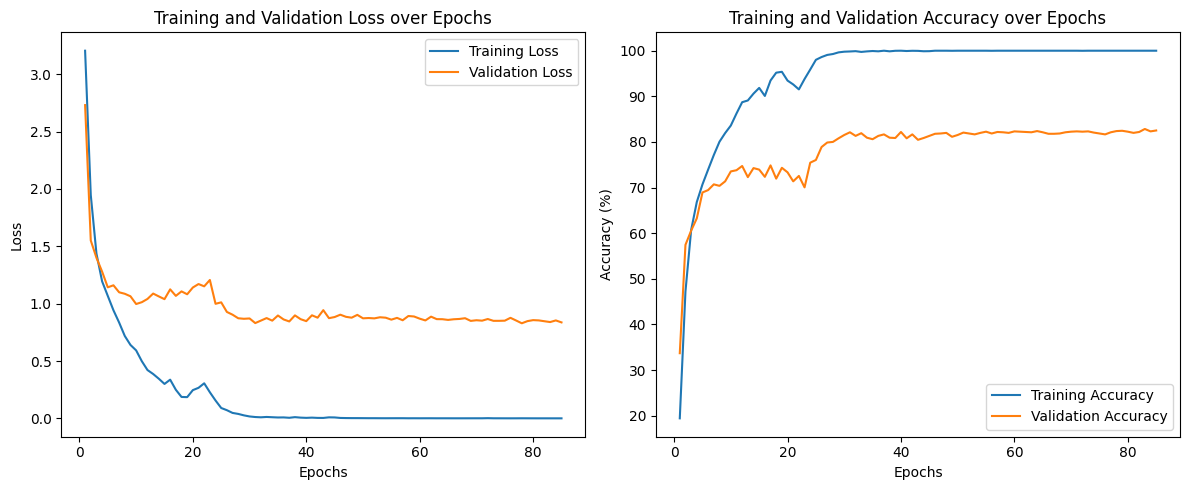

Test Loss: 0.9477, Test Accuracy: 79.58%


In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming `model` is an instance of EfficientNet-B0

# Function to get all convolutional layers
def get_conv_layers(model):
    conv_layers = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            conv_layers.append((name, layer))
    return conv_layers

# Group filters into a specified number of groups
def group_filters(conv_layer, num_groups):
    num_filters = conv_layer.weight.size(0)
    group_size = num_filters // num_groups
    groups = [list(range(i * group_size, (i + 1) * group_size)) for i in range(num_groups)]
    if num_filters % num_groups != 0:
        groups[-1].extend(range(num_groups * group_size, num_filters))
    return groups

# Convert layer groups to one-hot numpy array
def layer_groups_to_one_hot(num_layers, num_groups, num_groups_to_unfreeze):
    total_groups = num_layers * num_groups
    one_hot_array = np.zeros(total_groups, dtype=int)
    if num_groups_to_unfreeze > 0:
        one_hot_array[-num_groups_to_unfreeze:] = 1
    return one_hot_array

# Convert one-hot index to layer and group
def one_hot_index_to_layer_group(index, num_groups):
    layer = index // num_groups
    group = index % num_groups
    return layer, group

# Freeze the entire model except fully connected layers
def freeze_model_except_fc(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            for param in module.parameters():
                param.requires_grad = False
        else:
            for param in module.parameters():
                param.requires_grad = True

# Unfreeze specific groups of filters based on the one-hot array
def unfreeze_groups(model, one_hot_array, num_layers, num_groups):
    conv_layers = get_conv_layers(model)
    conv_layer_groups = [group_filters(layer[1], num_groups) for layer in conv_layers]

    for index in range(len(one_hot_array)):
        if one_hot_array[index] == 0:
            layer_index, group_index = one_hot_index_to_layer_group(index, num_groups)
            layer_name, layer = conv_layers[layer_index]
            for i in conv_layer_groups[layer_index][group_index]:
                layer.weight.grad[i] = 0
                if layer.bias is not None:
                    layer.bias.grad[i] = 0

# Training function with validation and testing
def train_model(model, train_loader, val_loader, num_groups_to_unfreeze, num_layers, num_groups, num_epochs=10, learning_rate=0.01):
    one_hot_array = layer_groups_to_one_hot(num_layers, num_groups, num_groups_to_unfreeze)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            unfreeze_groups(model, one_hot_array, num_layers, num_groups)
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            test_outputs = model(test_images)
            test_loss = criterion(test_outputs, test_labels)
            test_running_loss += test_loss.item()

            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

    test_loss = test_running_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy

# Example usage
model.load_state_dict(torch.load('model_state.pth'))
num_layers = len(get_conv_layers(model))
num_groups = 2
freeze_model_except_fc(model)

epochs = 85
one_hot_array = layer_groups_to_one_hot(num_layers, num_groups, 0)
num_layers_unfreeze = 0
print(f'Training... with total group layers {len(one_hot_array)}, divided by groups of {num_groups} per layer')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f'--- group layers unfreezed: {num_layers_unfreeze} ')
    tl, ta, vl, va = train_model(model, train_loader, val_loader, num_groups_to_unfreeze=num_layers_unfreeze, num_layers=num_layers, num_groups=num_groups, num_epochs=1)
    num_layers_unfreeze += 5
    train_losses.extend(tl)
    train_accuracies.extend(ta)
    val_losses.extend(vl)
    val_accuracies.extend(va)

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = evaluate_model(model, test_loader)

Training... with total group layers 104, divided by groups of 2 per layer
--- group layers unfreezed: 0 
Epoch [1/1], Train Loss: 3.2114, Train Accuracy: 19.81%, Val Loss: 2.7611, Val Accuracy: 32.59%
--- group layers unfreezed: 7 
Epoch [1/1], Train Loss: 1.9535, Train Accuracy: 47.34%, Val Loss: 1.6455, Val Accuracy: 52.11%
--- group layers unfreezed: 14 
Epoch [1/1], Train Loss: 1.4629, Train Accuracy: 59.44%, Val Loss: 1.3725, Val Accuracy: 60.22%
--- group layers unfreezed: 21 
Epoch [1/1], Train Loss: 1.2201, Train Accuracy: 66.05%, Val Loss: 1.1772, Val Accuracy: 67.88%
--- group layers unfreezed: 28 
Epoch [1/1], Train Loss: 1.0807, Train Accuracy: 69.99%, Val Loss: 1.1514, Val Accuracy: 68.34%
--- group layers unfreezed: 35 
Epoch [1/1], Train Loss: 0.8995, Train Accuracy: 74.74%, Val Loss: 1.0654, Val Accuracy: 71.50%
--- group layers unfreezed: 42 
Epoch [1/1], Train Loss: 0.8028, Train Accuracy: 77.60%, Val Loss: 1.0076, Val Accuracy: 72.69%
--- group layers unfreezed: 49 


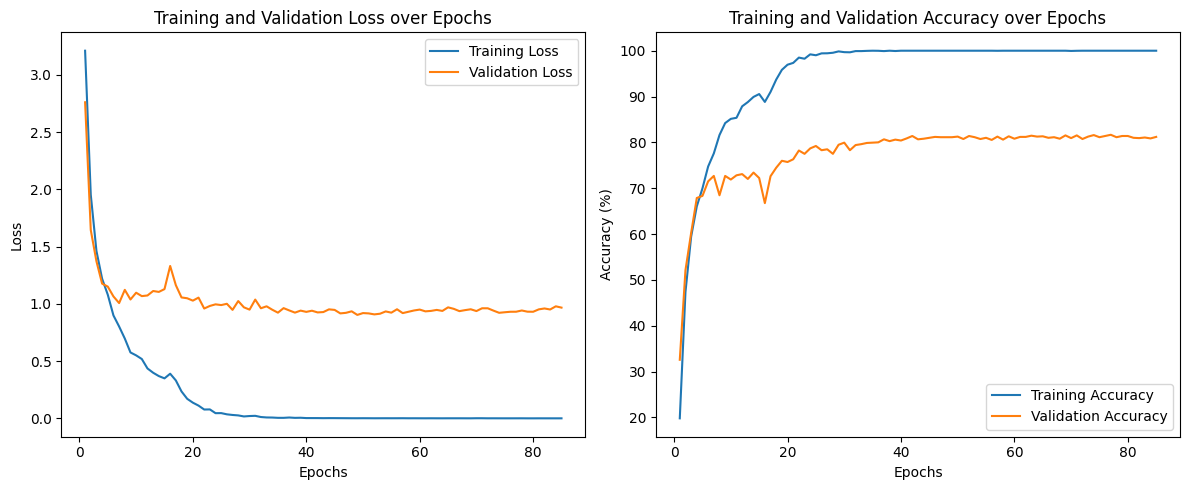

Test Loss: 1.0101, Test Accuracy: 78.89%


In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming `model` is an instance of EfficientNet-B0

# Function to get all convolutional layers
def get_conv_layers(model):
    conv_layers = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            conv_layers.append((name, layer))
    return conv_layers

# Group filters into a specified number of groups
def group_filters(conv_layer, num_groups):
    num_filters = conv_layer.weight.size(0)
    group_size = num_filters // num_groups
    groups = [list(range(i * group_size, (i + 1) * group_size)) for i in range(num_groups)]
    if num_filters % num_groups != 0:
        groups[-1].extend(range(num_groups * group_size, num_filters))
    return groups

# Convert layer groups to one-hot numpy array
def layer_groups_to_one_hot(num_layers, num_groups, num_groups_to_unfreeze):
    total_groups = num_layers * num_groups
    one_hot_array = np.zeros(total_groups, dtype=int)
    if num_groups_to_unfreeze > 0:
        one_hot_array[-num_groups_to_unfreeze:] = 1
    return one_hot_array

# Convert one-hot index to layer and group
def one_hot_index_to_layer_group(index, num_groups):
    layer = index // num_groups
    group = index % num_groups
    return layer, group

# Freeze the entire model except fully connected layers
def freeze_model_except_fc(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            for param in module.parameters():
                param.requires_grad = False
        else:
            for param in module.parameters():
                param.requires_grad = True

# Unfreeze specific groups of filters based on the one-hot array
def unfreeze_groups(model, one_hot_array, num_layers, num_groups):
    conv_layers = get_conv_layers(model)
    conv_layer_groups = [group_filters(layer[1], num_groups) for layer in conv_layers]

    for index in range(len(one_hot_array)):
        if one_hot_array[index] == 0:
            layer_index, group_index = one_hot_index_to_layer_group(index, num_groups)
            layer_name, layer = conv_layers[layer_index]
            for i in conv_layer_groups[layer_index][group_index]:
                layer.weight.grad[i] = 0
                if layer.bias is not None:
                    layer.bias.grad[i] = 0

# Training function with validation and testing
def train_model(model, train_loader, val_loader, num_groups_to_unfreeze, num_layers, num_groups, num_epochs=10, learning_rate=0.01):
    one_hot_array = layer_groups_to_one_hot(num_layers, num_groups, num_groups_to_unfreeze)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            unfreeze_groups(model, one_hot_array, num_layers, num_groups)
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            test_outputs = model(test_images)
            test_loss = criterion(test_outputs, test_labels)
            test_running_loss += test_loss.item()

            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

    test_loss = test_running_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy

# Example usage
model.load_state_dict(torch.load('model_state.pth'))
num_layers = len(get_conv_layers(model))
num_groups = 2
freeze_model_except_fc(model)

epochs = 85
one_hot_array = layer_groups_to_one_hot(num_layers, num_groups, 0)
num_layers_unfreeze = 0
print(f'Training... with total group layers {len(one_hot_array)}, divided by groups of {num_groups} per layer')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f'--- group layers unfreezed: {num_layers_unfreeze} ')
    tl, ta, vl, va = train_model(model, train_loader, val_loader, num_groups_to_unfreeze=num_layers_unfreeze, num_layers=num_layers, num_groups=num_groups, num_epochs=1)
    num_layers_unfreeze += 7
    train_losses.extend(tl)
    train_accuracies.extend(ta)
    val_losses.extend(vl)
    val_accuracies.extend(va)

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = evaluate_model(model, test_loader)

Training... with total group layers 104, divided by groups of 2 per layer
--- group layers unfreezed: 0 
Epoch [1/1], Train Loss: 3.2892, Train Accuracy: 15.37%, Val Loss: 2.8594, Val Accuracy: 30.80%
--- group layers unfreezed: 9 
Epoch [1/1], Train Loss: 2.1224, Train Accuracy: 42.49%, Val Loss: 1.7874, Val Accuracy: 50.07%
--- group layers unfreezed: 18 
Epoch [1/1], Train Loss: 1.5745, Train Accuracy: 55.94%, Val Loss: 1.3656, Val Accuracy: 61.02%
--- group layers unfreezed: 27 
Epoch [1/1], Train Loss: 1.2649, Train Accuracy: 65.34%, Val Loss: 1.1157, Val Accuracy: 69.99%
--- group layers unfreezed: 36 
Epoch [1/1], Train Loss: 1.0448, Train Accuracy: 71.30%, Val Loss: 1.1240, Val Accuracy: 69.39%
--- group layers unfreezed: 45 
Epoch [1/1], Train Loss: 0.9117, Train Accuracy: 75.17%, Val Loss: 1.1107, Val Accuracy: 69.66%
--- group layers unfreezed: 54 
Epoch [1/1], Train Loss: 0.7743, Train Accuracy: 78.82%, Val Loss: 1.0016, Val Accuracy: 73.61%
--- group layers unfreezed: 63 


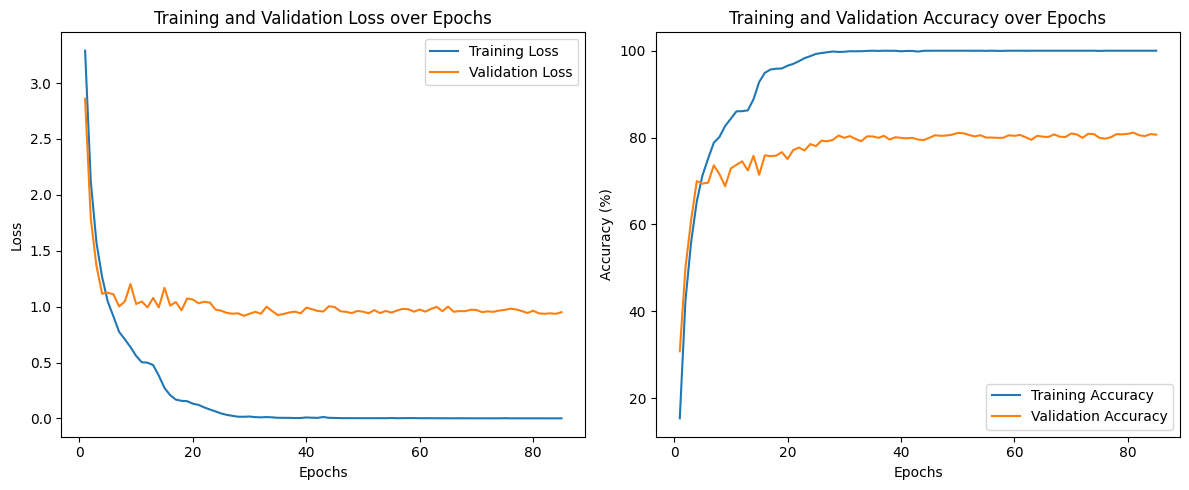

Test Loss: 0.9852, Test Accuracy: 78.89%


In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming `model` is an instance of EfficientNet-B0

# Function to get all convolutional layers
def get_conv_layers(model):
    conv_layers = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            conv_layers.append((name, layer))
    return conv_layers

# Group filters into a specified number of groups
def group_filters(conv_layer, num_groups):
    num_filters = conv_layer.weight.size(0)
    group_size = num_filters // num_groups
    groups = [list(range(i * group_size, (i + 1) * group_size)) for i in range(num_groups)]
    if num_filters % num_groups != 0:
        groups[-1].extend(range(num_groups * group_size, num_filters))
    return groups

# Convert layer groups to one-hot numpy array
def layer_groups_to_one_hot(num_layers, num_groups, num_groups_to_unfreeze):
    total_groups = num_layers * num_groups
    one_hot_array = np.zeros(total_groups, dtype=int)
    if num_groups_to_unfreeze > 0:
        one_hot_array[-num_groups_to_unfreeze:] = 1
    return one_hot_array

# Convert one-hot index to layer and group
def one_hot_index_to_layer_group(index, num_groups):
    layer = index // num_groups
    group = index % num_groups
    return layer, group

# Freeze the entire model except fully connected layers
def freeze_model_except_fc(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            for param in module.parameters():
                param.requires_grad = False
        else:
            for param in module.parameters():
                param.requires_grad = True

# Unfreeze specific groups of filters based on the one-hot array
def unfreeze_groups(model, one_hot_array, num_layers, num_groups):
    conv_layers = get_conv_layers(model)
    conv_layer_groups = [group_filters(layer[1], num_groups) for layer in conv_layers]

    for index in range(len(one_hot_array)):
        if one_hot_array[index] == 0:
            layer_index, group_index = one_hot_index_to_layer_group(index, num_groups)
            layer_name, layer = conv_layers[layer_index]
            for i in conv_layer_groups[layer_index][group_index]:
                layer.weight.grad[i] = 0
                if layer.bias is not None:
                    layer.bias.grad[i] = 0

# Training function with validation and testing
def train_model(model, train_loader, val_loader, num_groups_to_unfreeze, num_layers, num_groups, num_epochs=10, learning_rate=0.01):
    one_hot_array = layer_groups_to_one_hot(num_layers, num_groups, num_groups_to_unfreeze)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            unfreeze_groups(model, one_hot_array, num_layers, num_groups)
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            test_outputs = model(test_images)
            test_loss = criterion(test_outputs, test_labels)
            test_running_loss += test_loss.item()

            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

    test_loss = test_running_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy

# Example usage
model.load_state_dict(torch.load('model_state.pth'))
num_layers = len(get_conv_layers(model))
num_groups = 2
freeze_model_except_fc(model)

epochs = 85
one_hot_array = layer_groups_to_one_hot(num_layers, num_groups, 0)
num_layers_unfreeze = 0
print(f'Training... with total group layers {len(one_hot_array)}, divided by groups of {num_groups} per layer')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f'--- group layers unfreezed: {num_layers_unfreeze} ')
    tl, ta, vl, va = train_model(model, train_loader, val_loader, num_groups_to_unfreeze=num_layers_unfreeze, num_layers=num_layers, num_groups=num_groups, num_epochs=1)
    num_layers_unfreeze += 9
    train_losses.extend(tl)
    train_accuracies.extend(ta)
    val_losses.extend(vl)
    val_accuracies.extend(va)

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = evaluate_model(model, test_loader)

Training... with total group layers 104, divided by groups of 2 per layer
--- group layers unfreezed: 0 
Epoch [1/1], Train Loss: 3.2183, Train Accuracy: 18.21%, Val Loss: 2.7502, Val Accuracy: 33.77%
--- group layers unfreezed: 11 
Epoch [1/1], Train Loss: 1.9770, Train Accuracy: 46.49%, Val Loss: 1.5717, Val Accuracy: 56.66%
--- group layers unfreezed: 22 
Epoch [1/1], Train Loss: 1.4637, Train Accuracy: 59.16%, Val Loss: 1.3115, Val Accuracy: 63.13%
--- group layers unfreezed: 33 
Epoch [1/1], Train Loss: 1.1980, Train Accuracy: 67.04%, Val Loss: 1.1748, Val Accuracy: 67.81%
--- group layers unfreezed: 44 
Epoch [1/1], Train Loss: 1.0393, Train Accuracy: 71.16%, Val Loss: 1.1498, Val Accuracy: 68.27%
--- group layers unfreezed: 55 
Epoch [1/1], Train Loss: 0.8478, Train Accuracy: 76.33%, Val Loss: 1.0508, Val Accuracy: 71.64%
--- group layers unfreezed: 66 
Epoch [1/1], Train Loss: 0.7706, Train Accuracy: 78.87%, Val Loss: 1.0655, Val Accuracy: 72.10%
--- group layers unfreezed: 77 

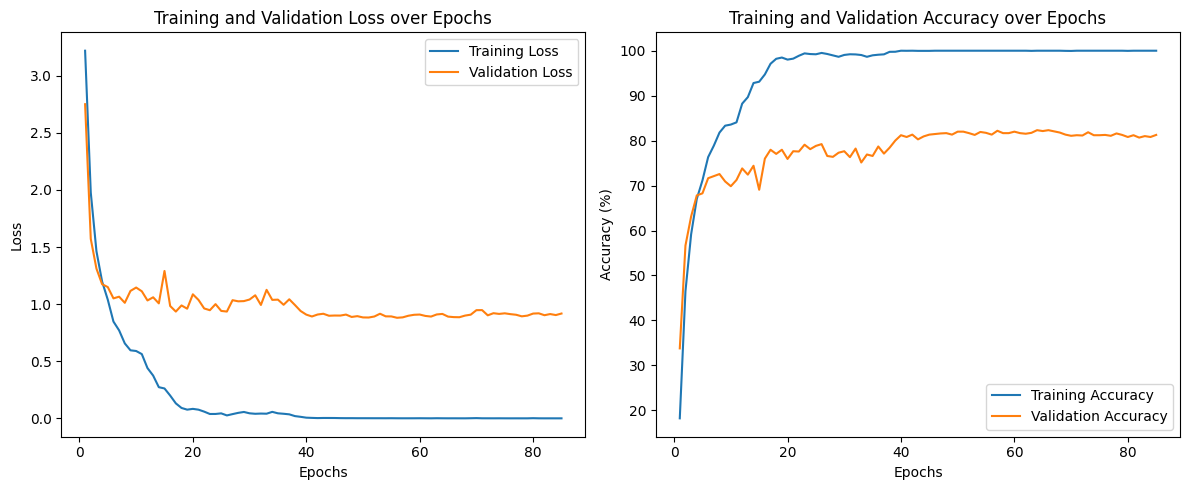

Test Loss: 1.0493, Test Accuracy: 78.73%


In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming `model` is an instance of EfficientNet-B0

# Function to get all convolutional layers
def get_conv_layers(model):
    conv_layers = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            conv_layers.append((name, layer))
    return conv_layers

# Group filters into a specified number of groups
def group_filters(conv_layer, num_groups):
    num_filters = conv_layer.weight.size(0)
    group_size = num_filters // num_groups
    groups = [list(range(i * group_size, (i + 1) * group_size)) for i in range(num_groups)]
    if num_filters % num_groups != 0:
        groups[-1].extend(range(num_groups * group_size, num_filters))
    return groups

# Convert layer groups to one-hot numpy array
def layer_groups_to_one_hot(num_layers, num_groups, num_groups_to_unfreeze):
    total_groups = num_layers * num_groups
    one_hot_array = np.zeros(total_groups, dtype=int)
    if num_groups_to_unfreeze > 0:
        one_hot_array[-num_groups_to_unfreeze:] = 1
    return one_hot_array

# Convert one-hot index to layer and group
def one_hot_index_to_layer_group(index, num_groups):
    layer = index // num_groups
    group = index % num_groups
    return layer, group

# Freeze the entire model except fully connected layers
def freeze_model_except_fc(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            for param in module.parameters():
                param.requires_grad = False
        else:
            for param in module.parameters():
                param.requires_grad = True

# Unfreeze specific groups of filters based on the one-hot array
def unfreeze_groups(model, one_hot_array, num_layers, num_groups):
    conv_layers = get_conv_layers(model)
    conv_layer_groups = [group_filters(layer[1], num_groups) for layer in conv_layers]

    for index in range(len(one_hot_array)):
        if one_hot_array[index] == 0:
            layer_index, group_index = one_hot_index_to_layer_group(index, num_groups)
            layer_name, layer = conv_layers[layer_index]
            for i in conv_layer_groups[layer_index][group_index]:
                layer.weight.grad[i] = 0
                if layer.bias is not None:
                    layer.bias.grad[i] = 0

# Training function with validation and testing
def train_model(model, train_loader, val_loader, num_groups_to_unfreeze, num_layers, num_groups, num_epochs=10, learning_rate=0.01):
    one_hot_array = layer_groups_to_one_hot(num_layers, num_groups, num_groups_to_unfreeze)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            unfreeze_groups(model, one_hot_array, num_layers, num_groups)
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            test_outputs = model(test_images)
            test_loss = criterion(test_outputs, test_labels)
            test_running_loss += test_loss.item()

            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

    test_loss = test_running_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy

# Example usage
model.load_state_dict(torch.load('model_state.pth'))
num_layers = len(get_conv_layers(model))
num_groups = 2
freeze_model_except_fc(model)

epochs = 85
one_hot_array = layer_groups_to_one_hot(num_layers, num_groups, 0)
num_layers_unfreeze = 0
print(f'Training... with total group layers {len(one_hot_array)}, divided by groups of {num_groups} per layer')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f'--- group layers unfreezed: {num_layers_unfreeze} ')
    tl, ta, vl, va = train_model(model, train_loader, val_loader, num_groups_to_unfreeze=num_layers_unfreeze, num_layers=num_layers, num_groups=num_groups, num_epochs=1)
    num_layers_unfreeze += 11
    train_losses.extend(tl)
    train_accuracies.extend(ta)
    val_losses.extend(vl)
    val_accuracies.extend(va)

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = evaluate_model(model, test_loader)